In [6]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import nltk
import re

from nltk.corpus import stopwords
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup

# Lettura file

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data/chatGPTreviews.csv", usecols=['tweets', 'labels'])
labels_dict = {"neutral": 0, "good": 1, "bad": 2}
data = data.replace({'labels': labels_dict})
data

Mounted at /content/gdrive/


,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,0
1,"Try talking with ChatGPT, our new AI system wh...",1
2,ChatGPT: Optimizing Language Models for Dialog...,0
3,"THRILLED to share that ChatGPT, our new model ...",1
4,"As of 2 minutes ago, @OpenAI released their ne...",2
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,2
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,1
219291,chatgpt is being disassembled until it can onl...,2
219292,2023 predictions by #chatGPT. Nothing really s...,2


# Pre-processing

In [8]:
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def preprocessing(text):
  text = text.lower()

  text = re.sub(r"[^a-zA-Z?.!,¿]+", " ",text)
  text = re.sub(r"http\S+", "", text)
  html = re.compile(r'<.*?>')
  text = html.sub(r'', text)

  punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
  for p in punctuations:
      text = text.replace(p, '')

  text = [word.lower() for word in text.split() if word.lower() not in sw]

  text = " ".join(text)

  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

data['tweets'] = data['tweets'].apply(lambda x: preprocessing(x))


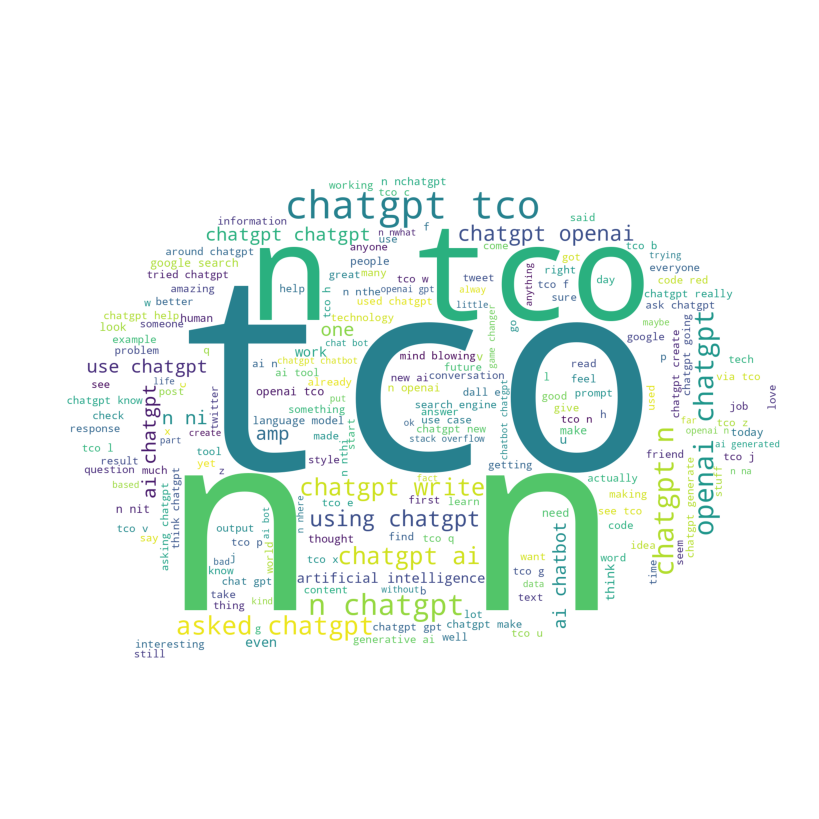

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

comment_words = ''
stopwords = set(STOPWORDS)

for val in data['tweets']:
    val = str(val)
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

mask = np.array(Image.open("/content/gdrive/MyDrive/Colab Notebooks/nuvola.png"))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, mask=mask).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [11]:
shuffled_data = data.copy()
random_states = 5
shuffled_data = shuffled_data.sample(frac=1,random_state=random_states)
shuffled_data

,tweets,labels
33914,bitcoin worth much backed full faith credit gr...,1
102836,chatgpt beating google every single query tco ...,2
38412,chatgpt generate ruby code check user exists g...,2
118107,ready another project persistence tech sixpath...,0
158256,may pass text persuasive come expect little te...,2
...,...,...
121974,please stop posting chatgpt promptd literally ...,1
124605,week newsletter generative ai n china new rule...,1
20463,chatgpt coming pretty good tweet ideas spermat...,1
18638,chatgpt putting job yet good fun tco cl jkytero,1


# Tokenizzazione

In [12]:
tweets = shuffled_data['tweets'].values
labels = shuffled_data['labels'].values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
max_lenght_sentence = 0

for sentence in tweets:
  token = tokenizer.encode(sentence, add_special_tokens=True)
  max_lenght_sentence = max(max_lenght_sentence, len(token))

print(f"Max sentence length is {max_lenght_sentence}")

Max sentence length is 110


In [14]:
input_ids = []
attention_masks = []

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # sentence to encode
                        add_special_tokens = True, # add '[CLS]' and '[SEP]'
                        max_length = max_lenght_sentence,           # pad & truncate all sentences
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # construct attn. masks
                        return_tensors = 'pt',     # return pytorch tensors
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(tweets) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tweets[index])
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

genre future prompt directed various ais eg chatgpt dalle
╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ genre    │        6907 │                1 │
├──────────┼─────────────┼──────────────────┤
│ future   │        2925 │                1 │
├──────────┼─────────────┼──────────────────┤
│ prompt   │       25732 │                1 │
├──────────┼─────────────┼──────────────────┤
│ directed │        2856 │                1 │
├──────────┼─────────────┼──────────────────┤
│ various  │        2536 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ai       │        9932 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##s      │        2015 │                1 │
├──────────┼─────────────┼──────────────────┤
│ e        │        1041 │                1 │
├──────────┼──────────

# Train validation split

In [16]:
dataset = TensorDataset(input_ids, attention_masks, labels)

# 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

175,435 training samples
43,859 validation samples


In [17]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Prediction metrics

In [18]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

# BERT model

In [19]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''if device == "cuda:0":
# Tell pytorch to run this model on the GPU.
    model = model.cuda()'''
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [4]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [3]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
epochs = 4

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]